This exercise is prepared for the **Advanced GIS Spatial Big Data** lecture offered in spring 2023 by Moritz Neun (Zürich) in collaboration with the Chair of Geoinformation Engineering (Institute of Cartography and Geoinformation, ETH Zürich).

Date updated: 2023-02-15

Instructor: Dr. Moritz Neun

# Lab 2-1: Parallel processing using Dask

Dask is a parallel and distributed computing library that scales the existing Python and PyData ecosystem. Hence it brings together parallel processing like in the Hadoop and Spark world with Pythonic data processing known from Pandas.

Dask provides multi-core and distributed+parallel execution on larger-than-memory datasets. Most of the times when you are using Dask, you will be using a distributed scheduler, which exists in the context of a Dask cluster. Also when used on a single local machine, distributed Dask processes are an easy and stable way for parallelizing Python processing.

For more information on Dask, see e.g. https://tutorial.dask.org/00_overview.html

In this Lab we'll use Dask for different use-cases:
* (1) Reading a large number files directly from a remote storage
* (2) Parallelizing K-Means clustering using Dask
* (3) Dask and Parquet for working with OSM
* (4) Dask distributed for processing large datasets on a cluster

## (1) Speed-up data loading from remote storage

In this use-case we'll explore how Dask can be used to speed-up reading files from a remote file system like S3 (also applies to other distributed file systems HDFS, GFS, ...).

Reading directly from a distributed file system is often used in serverless computing and massively parallel distributed computations where the choice of the data to be read is only decided during run-time and where the total amount of data cannot be staged on each computing node.

As a first experiment we'll read CSV files which are located on a public S3 server owned by Transport for London. The files do contain readings from traffic counters in London. The total dataset contains more than 10'000 files. For convenience the paths of all files are provided as a json file in this repository.

In [1]:
import json
import pandas as pd

with open('tfl-tims-s3paths.json', 'r') as f:
    tims_csv_s3 = json.load(f)
tims_csv_s3[:5]

['s3://roads.data.tfl.gov.uk/TIMS/detdata01012019-000023.csv',
 's3://roads.data.tfl.gov.uk/TIMS/detdata01012019-001521.csv',
 's3://roads.data.tfl.gov.uk/TIMS/detdata01012019-003023.csv',
 's3://roads.data.tfl.gov.uk/TIMS/detdata01012019-004522.csv',
 's3://roads.data.tfl.gov.uk/TIMS/detdata01012019-010026.csv']

### Baseline performance reading sequentially using Pandas

Let's first measure the time it takes to read 30 files using Pandas.

In [2]:
%%time
tims_dfs = []
for p in tims_csv_s3[:30]:
    tims_dfs.append(pd.read_csv(p))
tims_df = pd.concat(tims_dfs)
tims_df

CPU times: user 3.13 s, sys: 677 ms, total: 3.81 s
Wall time: 20.9 s


,TIMESTAMP,NODE,EASTING,NORTHING,FLOW_ACTUAL_15M,SAT_BANDINGS,DETECTOR_NO,TOTAL_DETECTOR_NO,DETECTOR_RATE
0,2018-12-31T23:48:00Z,09/017,529375.89,175212.75,304,0-79%,8,8,1.00
1,2018-12-31T23:47:00Z,09/017,529375.89,175212.75,303,0-79%,8,8,1.00
2,2018-12-31T23:46:00Z,09/017,529375.89,175212.75,314,0-79%,8,8,1.00
3,2018-12-31T23:45:00Z,09/017,529375.89,175212.75,322,0-79%,8,8,1.00
4,2018-12-31T23:44:00Z,09/017,529375.89,175212.75,334,0-79%,8,8,1.00
...,...,...,...,...,...,...,...,...,...
50609,2019-01-01T07:11:00Z,09/028,532412.43,173678.42,88,0-79%,3,4,0.75
50610,2019-01-01T07:11:00Z,09/358,531532.10,176592.00,85,0-79%,1,1,1.00
50611,2019-01-01T07:11:00Z,09/363,529780.16,170473.01,88,0-79%,3,4,0.75
50612,2019-01-01T07:11:00Z,09/364,530085.00,174806.00,105,80-89%,4,4,1.00


With that tims_df now is a normal Pandas Dataframe and supports all kinds of analytics.

In [3]:
%%time
# TODO calculate the mean flow and mean detector rate as well as the number of readings per counter node (2 lines).
??
pd_groups

CPU times: user 61.6 ms, sys: 5.43 ms, total: 67 ms
Wall time: 67.1 ms


FLOW_ACTUAL_15M                   DETECTOR_RATE
                  mean         std count          mean
NODE                                                  
00/002       56.216667   70.100870   420      0.846976
00/003      105.150000   41.198268   420      0.765714
00/004      163.342857   96.935166   420      0.990476
00/005      220.628571  101.638947    35      1.000000
00/006       85.008571  104.143181   350      0.284971
...                ...         ...   ...           ...
32/208      482.952703  107.093153   148      1.000000
32/209      639.817778  248.363263   225      1.000000
32/210      410.883436  131.589682   163      1.000000
32/228       69.285714   41.339920    14      1.000000
32/229      108.301075  101.148525   279      0.930896

[3593 rows x 4 columns]

### Performance reading parallel using Dask on the local computer

Let's now measure the time it takes to read 30 files using Dask. For that purpose we start a local Dask Client which will start a LocalCluster in the background. You can adjust the number of workers and threads as well as the memory according to the capabilities of your local computer. Usually it's advisable to use as many workers as CPUs.

In [4]:
import dask
import dask.dataframe as dd
from dask.distributed import Client
local_client = Client(n_workers=4, threads_per_worker=2, processes=True,
                      memory_limit='8GB', local_directory='/tmp',
                      scheduler_port=8986, dashboard_address='localhost:8987')
local_client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8987/status,
Dashboard: http://127.0.0.1:8987/status,Workers: 4
Total threads: 8,Total memory: 29.80 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:8986,Workers: 4
Dashboard: http://127.0.0.1:8987/status,Total threads: 8
Started: Just now,Total memory: 29.80 GiB
Comm: tcp://127.0.0.1:59422,Total threads: 2
Dashboard: http://127.0.0.1:59425/status,Memory: 7.45 GiB
Nanny: tcp://127.0.0.1:59413,


Let's now first just look at 3 files for testing. The read_csv method in Dask accepts lists of files as well as wildcards in the path. When looking at tims_ddf below it's visible Dask has not loaded the data yet, it has investigated the input paths and intelligently created a set of jobs for each chunk – one per CSV file in this case.

For more information on creating a Dask DataFrame, see https://tutorial.dask.org/01_dataframe.html

In [5]:
%%time
tims_ddf = dd.read_csv(tims_csv_s3[:3], dtype={'DETECTOR_RATE': 'float64'},
                       storage_options={'anon': True})
tims_ddf

CPU times: user 172 ms, sys: 56.5 ms, total: 228 ms
Wall time: 1.2 s


,TIMESTAMP,NODE,EASTING,NORTHING,FLOW_ACTUAL_15M,SAT_BANDINGS,DETECTOR_NO,TOTAL_DETECTOR_NO,DETECTOR_RATE
npartitions=3,,,,,,,,,
,string,string,float64,float64,int64,string,int64,int64,float64
,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...


In [6]:
tims_ddf.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 9 entries, TIMESTAMP to DETECTOR_RATE
dtypes: float64(3), int64(3), string(3)

So the DataFrame info() also shows the number of files and the columns with datatypes. Now let's run compute() which will actually read the data. It's important to know that compute will also transfer the data to the local memory (the one the client is running, so usually the local computer). After that computations on the DataFrame are very fast. However, this is only adivseable for small to medium-sized datasets. Later we'll look into scheduling remote computation on a cluster without transfering the data.

In [7]:
%%time
tims_ddf.compute()

CPU times: user 151 ms, sys: 50.9 ms, total: 202 ms
Wall time: 2.7 s


,TIMESTAMP,NODE,EASTING,NORTHING,FLOW_ACTUAL_15M,SAT_BANDINGS,DETECTOR_NO,TOTAL_DETECTOR_NO,DETECTOR_RATE
0,2018-12-31T23:48:00Z,09/017,529375.89,175212.75,304,0-79%,8,8,1.00
1,2018-12-31T23:47:00Z,09/017,529375.89,175212.75,303,0-79%,8,8,1.00
2,2018-12-31T23:46:00Z,09/017,529375.89,175212.75,314,0-79%,8,8,1.00
3,2018-12-31T23:45:00Z,09/017,529375.89,175212.75,322,0-79%,8,8,1.00
4,2018-12-31T23:44:00Z,09/017,529375.89,175212.75,334,0-79%,8,8,1.00
...,...,...,...,...,...,...,...,...,...
43610,2019-01-01T00:19:00Z,18/163,551598.00,176468.00,64,0-79%,2,3,0.67
43611,2019-01-01T00:18:00Z,18/163,551598.00,176468.00,63,0-79%,2,3,0.67
43612,2019-01-01T00:17:00Z,18/163,551598.00,176468.00,58,0-79%,2,3,0.67
43613,2019-01-01T00:16:00Z,18/163,551598.00,176468.00,58,0-79%,2,3,0.67


Let's now directly read and compute 30 files. As indicated this will use the local Dask cluster and afterwards provide the data in a local DataFrame useable like Pandas. The downloading and reading is done on the same computer as in the Pandas benchmark above, nevertheless we can see a performance improvement as the multiple parallel processes can use the IO bandwidth better and minimize latency losses.

In [8]:
%%time
tims_ddf = dd.read_csv(tims_csv_s3[:30], dtype={'DETECTOR_RATE': 'float64'},
                       storage_options={'anon': True}).compute()
tims_ddf

CPU times: user 1.27 s, sys: 384 ms, total: 1.65 s
Wall time: 15.2 s


,TIMESTAMP,NODE,EASTING,NORTHING,FLOW_ACTUAL_15M,SAT_BANDINGS,DETECTOR_NO,TOTAL_DETECTOR_NO,DETECTOR_RATE
0,2018-12-31T23:48:00Z,09/017,529375.89,175212.75,304,0-79%,8,8,1.00
1,2018-12-31T23:47:00Z,09/017,529375.89,175212.75,303,0-79%,8,8,1.00
2,2018-12-31T23:46:00Z,09/017,529375.89,175212.75,314,0-79%,8,8,1.00
3,2018-12-31T23:45:00Z,09/017,529375.89,175212.75,322,0-79%,8,8,1.00
4,2018-12-31T23:44:00Z,09/017,529375.89,175212.75,334,0-79%,8,8,1.00
...,...,...,...,...,...,...,...,...,...
50609,2019-01-01T07:11:00Z,09/028,532412.43,173678.42,88,0-79%,3,4,0.75
50610,2019-01-01T07:11:00Z,09/358,531532.10,176592.00,85,0-79%,1,1,1.00
50611,2019-01-01T07:11:00Z,09/363,529780.16,170473.01,88,0-79%,3,4,0.75
50612,2019-01-01T07:11:00Z,09/364,530085.00,174806.00,105,80-89%,4,4,1.00


In [9]:
tims_ddf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1243271 entries, 0 to 50613
Data columns (total 9 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   TIMESTAMP          1243271 non-null  string 
 1   NODE               1243271 non-null  string 
 2   EASTING            1243271 non-null  float64
 3   NORTHING           1243271 non-null  float64
 4   FLOW_ACTUAL_15M    1243271 non-null  int64  
 5   SAT_BANDINGS       1243271 non-null  string 
 6   DETECTOR_NO        1243271 non-null  int64  
 7   TOTAL_DETECTOR_NO  1243271 non-null  int64  
 8   DETECTOR_RATE      1243271 non-null  float64
dtypes: float64(3), int64(3), string(3)
memory usage: 117.4 MB


The dataframe info now shows that we actually have all data in local memory and hence subsequent analysis like aggregations are very fast.

In [10]:
%%time
dd_groups = tims_ddf.groupby('NODE').agg(
    {'FLOW_ACTUAL_15M': ['mean', 'std', 'count'], 'DETECTOR_RATE': ['mean']})
dd_groups

CPU times: user 38.9 ms, sys: 4.02 ms, total: 42.9 ms
Wall time: 41.9 ms


FLOW_ACTUAL_15M                   DETECTOR_RATE
                  mean         std count          mean
NODE                                                  
00/002       56.216667   70.100870   420      0.846976
00/003      105.150000   41.198268   420      0.765714
00/004      163.342857   96.935166   420      0.990476
00/005      220.628571  101.638947    35      1.000000
00/006       85.008571  104.143181   350      0.284971
...                ...         ...   ...           ...
32/208      482.952703  107.093153   148      1.000000
32/209      639.817778  248.363263   225      1.000000
32/210      410.883436  131.589682   163      1.000000
32/228       69.285714   41.339920    14      1.000000
32/229      108.301075  101.148525   279      0.930896

[3593 rows x 4 columns]

## (2) Dask and Parquet for working with OSM

For this experiment we're first using the OSM data extract for Zurich which already has been converted to Parquet for easier processing. The Parquet file will be downloaded in the next step.

There is no need to convert the data on your own. If you want to use a different file in the future you can download raw pbf OSM data e.g. from https://download.bbbike.org/osm/bbbike/ and convert it using OSM-Parquetizer (see https://github.com/adrianulbona/osm-parquetizer/tree/master/src/main/java/io/github/adrianulbona/osm/parquet)
```
java -jar osm-parquetizer-1.0.1-SNAPSHOT.jar \
  --pbf-threads 4 --no-ways --no-relations zuerich.osm.pbf
```

There are also other tools such as Osmosis or PYROSM which would allow reading and converting
 (https://pyrosm.readthedocs.io/en/latest/basics.html#initializing-the-pyrosm-osm-reader-object). Pure Python like PYROSM usually works well with single city extracts. OSM-Parquetizer or Osmosis also can be used for whole-world snapshots. 

In [11]:
import gdown

gdown.download(
    'https://drive.google.com/uc?id=1MnI_Z35Kp63jhjbTSFs3thp8o4aV9sbx',
    'zuerich.osm.pbf.node.parquet', quiet=False
)

Downloading...
From (original): https://drive.google.com/uc?id=1MnI_Z35Kp63jhjbTSFs3thp8o4aV9sbx
From (redirected): https://drive.google.com/uc?id=1MnI_Z35Kp63jhjbTSFs3thp8o4aV9sbx&confirm=t&uuid=b80e6fd0-d79c-47f4-b512-9f4e14d11297
To: /Users/moritz/git/advancedgis23_lab2/zuerich.osm.pbf.node.parquet
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 111M/111M [00:07<00:00, 15.0MB/s]


'zuerich.osm.pbf.node.parquet'

In [12]:
pois = dd.read_parquet('zuerich.osm.pbf.node.parquet', engine='pyarrow', dtype_backend='pyarrow')
pois

,id,version,timestamp,changeset,uid,user_sid,tags,latitude,longitude
npartitions=1,,,,,,,,,
,int64[pyarrow],int32[pyarrow],int64[pyarrow],int64[pyarrow],int32[pyarrow],binary[pyarrow],"list<tags: struct<key: binary not null, value:...",double[pyarrow],double[pyarrow]
,...,...,...,...,...,...,...,...,...


In [13]:
#TODO how many nodes are in the pois DataFrame
??

5240915

In [14]:
import numpy as np

def tag_filter(m, keys=['amenity']):
    if type(m) is np.ndarray:
        for t in m:
            if type(t) == dict and t['key'].decode("utf-8") in keys:
                return True
    return False

def tag_value(m, keys=['amenity']):
    if type(m) is np.ndarray:
        for t in m:
            if type(t) == dict and t['key'].decode("utf-8") in keys:
                return t['value'].decode("utf-8")
    return ''

def tag_name(m, keys=['name']):
    if type(m) is np.ndarray:
        for t in m:
            if type(t) == dict and t['key'].decode("utf-8") in keys:
                return t['value'].decode("utf-8")
    return ''

pois = pois[pois['tags'].map(tag_filter)]
pois['amenity'] = pois['tags'].map(tag_value)
pois['name'] = pois['tags'].map(tag_value)
pois = pois.compute()
pois

,id,version,timestamp,changeset,uid,user_sid,tags,latitude,longitude,amenity,name
2849,25428826,-1,0,-1,-1,b'',"[{'key': b'access', 'value': b'private'} {'ke...",47.499723,8.752998,parking_entrance,parking_entrance
5382,26034032,-1,0,-1,-1,b'',"[{'key': b'amenity', 'value': b'ferry_terminal...",47.339045,8.567275,ferry_terminal,ferry_terminal
5408,26034069,-1,0,-1,-1,b'',"[{'key': b'amenity', 'value': b'ferry_terminal...",47.303032,8.589110,ferry_terminal,ferry_terminal
5441,26034104,-1,0,-1,-1,b'',"[{'key': b'amenity', 'value': b'ferry_terminal...",47.267674,8.638333,ferry_terminal,ferry_terminal
5455,26034121,-1,0,-1,-1,b'',"[{'key': b'amenity', 'value': b'ferry_terminal...",47.258503,8.675518,ferry_terminal,ferry_terminal
...,...,...,...,...,...,...,...,...,...,...,...
5239724,10607183715,-1,0,-1,-1,b'',"[{'key': b'amenity', 'value': b'vending_machin...",47.449508,8.702402,vending_machine,vending_machine
5239726,10607183717,-1,0,-1,-1,b'',"[{'key': b'amenity', 'value': b'waste_basket'}...",47.453100,8.705587,waste_basket,waste_basket
5239740,10607844225,-1,0,-1,-1,b'',"[{'key': b'amenity', 'value': b'restaurant'} ...",47.230468,8.853062,restaurant,restaurant
5239755,10607942506,-1,0,-1,-1,b'',"[{'key': b'amenity', 'value': b'bicycle_parkin...",47.417262,8.557144,bicycle_parking,bicycle_parking


In [15]:
#TODO how many nodes are present per amenity value (e.g. how many benches, restaurants, ...)
??

amenity
bench              17221
waste_basket        4866
vending_machine     3600
drinking_water      3068
restaurant          2752
                   ...  
nursery_school         1
bike_shop              1
skatepark              1
sports_centre          1
warehouse              1
Name: count, Length: 184, dtype: int64[pyarrow]

We'll use H3 and Folium for a simple Heatmap of POI counts in the Zurich area.
Let's assign an H3 cell id at level 5 to every POI:

In [16]:
import h3

pois['h3'] = ??
pois.head()

,id,version,timestamp,changeset,uid,user_sid,tags,latitude,longitude,amenity,name,h3
2849,25428826,-1,0,-1,-1,b'',"[{'key': b'access', 'value': b'private'}, {'ke...",47.499723,8.752998,parking_entrance,parking_entrance,891f8ed19b7ffff
5382,26034032,-1,0,-1,-1,b'',"[{'key': b'amenity', 'value': b'ferry_terminal...",47.339045,8.567275,ferry_terminal,ferry_terminal,891f8ed9e5bffff
5408,26034069,-1,0,-1,-1,b'',"[{'key': b'amenity', 'value': b'ferry_terminal...",47.303032,8.589110,ferry_terminal,ferry_terminal,891f8336963ffff
5441,26034104,-1,0,-1,-1,b'',"[{'key': b'amenity', 'value': b'ferry_terminal...",47.267674,8.638333,ferry_terminal,ferry_terminal,891f8ec9483ffff
5455,26034121,-1,0,-1,-1,b'',"[{'key': b'amenity', 'value': b'ferry_terminal...",47.258503,8.675518,ferry_terminal,ferry_terminal,891f8ec9573ffff


With that we can generate a simle heatmap again using the group by call:

In [17]:
poi_heatmap = pois[['h3']].groupby(by=['h3']).agg(count=("h3", "count"))
poi_heatmap = poi_heatmap.reset_index()
poi_heatmap.sort_values('count', ascending=False)

,h3,count
7651,891f8ed9547ffff,196
7655,891f8ed9557ffff,170
7997,891f8eda057ffff,170
7638,891f8ed950bffff,164
6626,891f8ed1d63ffff,147
...,...,...
5722,891f8ecab63ffff,1
5723,891f8ecab6bffff,1
5726,891f8ecab77ffff,1
2362,891f83a5683ffff,1


In [18]:
import folium
from geojson import Feature, Point, FeatureCollection
import json
import matplotlib

def get_bbox(coords):
    lat_min = 1e7
    lat_max = -1e7
    lon_min = 1e7
    lon_max = -1e7
    for lat, lon in coords:
        lat_min = min(lat_min, lat)
        lat_max = max(lat_max, lat)
        lon_min = min(lon_min, lon)
        lon_max = max(lon_max, lon)
    return [(lat_min, lon_min), (lat_max, lon_max)]
    

def h3df_to_geojson(df_hex, file_output=None, column_name="count"):
    list_features = []
    for _, row in df_hex.iterrows():
        try:
            geometry_for_row = {
                "type" : "Polygon",
                "coordinates": [h3.h3_to_geo_boundary(h=row["h3"], geo_json=True)]
            }
            properties_for_row = dict(row)
            feature = Feature(geometry=geometry_for_row , id=row["h3"], properties=properties_for_row)
            list_features.append(feature)
        except:
            print("Exception for h3 " + row["h3"]) 
    return json.dumps(FeatureCollection(list_features))

def h3heatmap(df_aggreg, column_name="count", fill_opacity=0.7, color_map_name="Blues", initial_map=None):
    # Color values
    min_value = df_aggreg[column_name].min()
    max_value = df_aggreg[column_name].max()
    mean_value = df_aggreg[column_name].mean()
    print(f"Color min value {min_value}, max value {max_value}, mean value {mean_value}")
    print(f"Hex cell count: {df_aggreg['h3'].nunique()}")
    
    # the name of the layer just needs to be unique, put something silly there for now:
    name_layer = "H3map " + str(df_aggreg)
    
    if initial_map is None:
        initial_map = folium.Map(location= [47, 4], zoom_start=5.5, tiles="cartodbpositron")

    #create geojson data from dataframe
    geojson_data = h3df_to_geojson(df_aggreg, column_name=column_name)

    # color_map_name 'Blues' for now, many more at 
    # https://matplotlib.org/stable/tutorials/colors/colormaps.html to choose from!
    custom_cm = matplotlib.cm.get_cmap(color_map_name)

    gjm = folium.GeoJson(
        geojson_data,
        style_function=lambda feature: {
            'fillColor': matplotlib.colors.to_hex(custom_cm(
                (feature['properties'][column_name]-min_value)/(max_value-min_value)
            )),
            'color': matplotlib.colors.to_hex(custom_cm(
                min(((feature['properties'][column_name]-min_value)/(max_value-min_value)+0.3), max_value)
            )),
            'weight': 2,
            'fillOpacity': fill_opacity,
        }, 
        name = name_layer
    )
    gjm.add_to(initial_map)
    initial_map.fit_bounds(gjm.get_bounds())
    
    folium.GeoJsonTooltip(list(df_aggreg.columns)).add_to(gjm)
    
    return initial_map


h3heatmap(poi_heatmap[poi_heatmap['count'] > 20])

Color min value 21, max value 196, mean value 43.22452830188679
Hex cell count: 530


Finally let's close the current local client to avoid side-effects in the next experiments.

In [19]:
local_client.close()

## (3) Dask distributed for processing large datasets on a cluster

For the following steps a remote cluster with multiple Dask worker nodes is provided.
Please follow the instructions in the lectore notes to establish a tunnel to the cluster.

In [21]:
import requests

class NoDaskTunnelException(Exception):
    def __init__(self):
        self.message = 'Establish the tunnel to the Dask cluster first. See the lecture slides for more information.'
        super().__init__(self.message)
    
try:
    x = requests.get('http://localhost:8787')
    if x.status_code != 200:
        raise Exception
except Exception:
    raise NoDaskTunnelException from None

print('You can test the connection by opening the Dask dashboard at http://localhost:8787')

NoDaskTunnelException: Establish the tunnel to the Dask cluster first. See the lecture slides for more information.

Now that the tunnel is established, we can continue.

In [ ]:
import pandas as pd
import dask
import dask.dataframe as dd
from dask.distributed import Client, wait

client = Client("localhost:8786")
client

In [ ]:
%%time
fosm = client.submit(dd.read_parquet, '/data/osm/europe-latest.osm.pbf.node.parquet',
                     split_row_groups=True, engine='pyarrow')
osmnodes = fosm.result()
osmnodes

In [ ]:
%%time
osmnodes.head()

The parquetfile europe-latest.osm.pbf.node.parquet contains 3 billion points in 496 partitions. Reading the metatdata and the head is fast. However, reading and filteringthe whole table initially takes 30 minutes, therefore the dataset was already persisted and published on the cluster before the exercise.

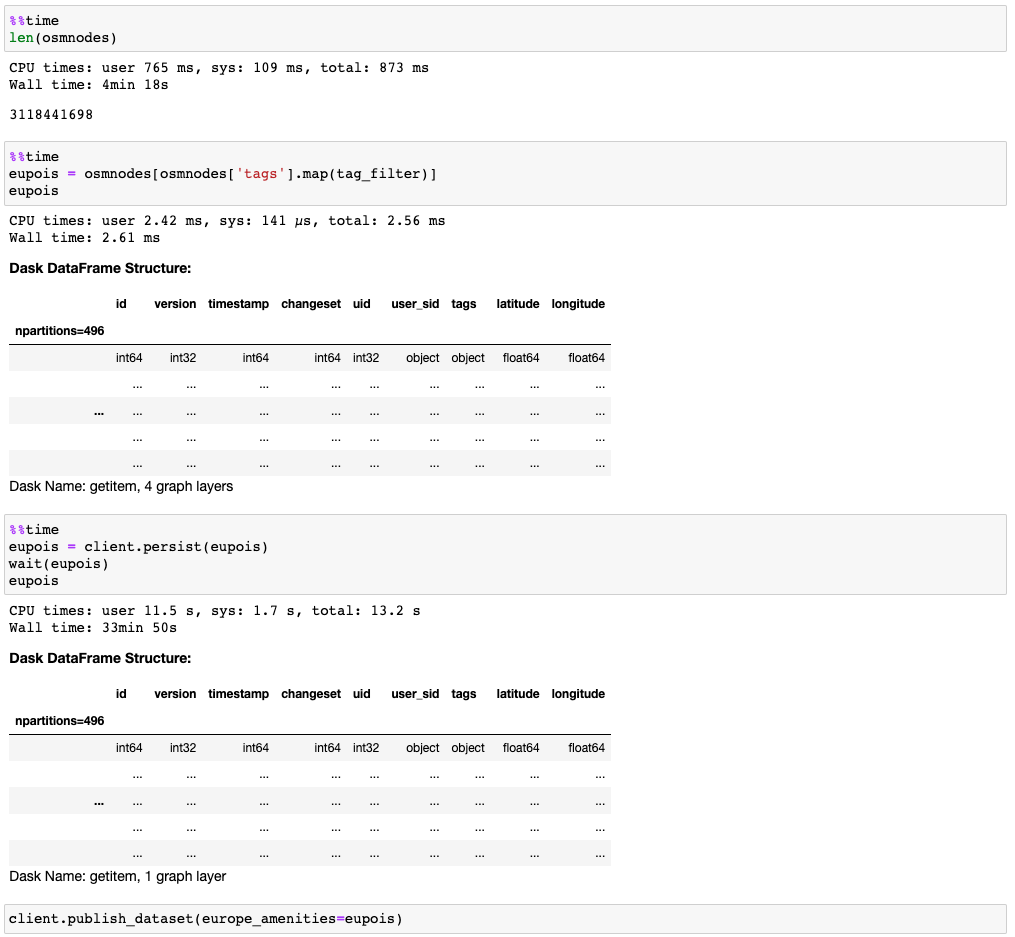

Published datasets can be read directly by name from the Dask cluster:

In [ ]:
client.list_datasets()

In [ ]:
eupois = client.get_dataset('europe_amenities')

In [ ]:
eupois.head()

In [ ]:
eupois['amenity'] = eupois['tags'].map(tag_value)
eupois['name'] = eupois['tags'].map(tag_value)
eupois

In [ ]:
eupois.head()

In [ ]:
%%time
#TODO how many nodes are present per amenity value (e.g. how many benches, restaurants, ...)
#NOTE: don't forget to call .compute() for getting the results!
eupois['amenity'].value_counts().compute()

If you look at the dashboard, the above call will result in such a set of parallel executed tasks:

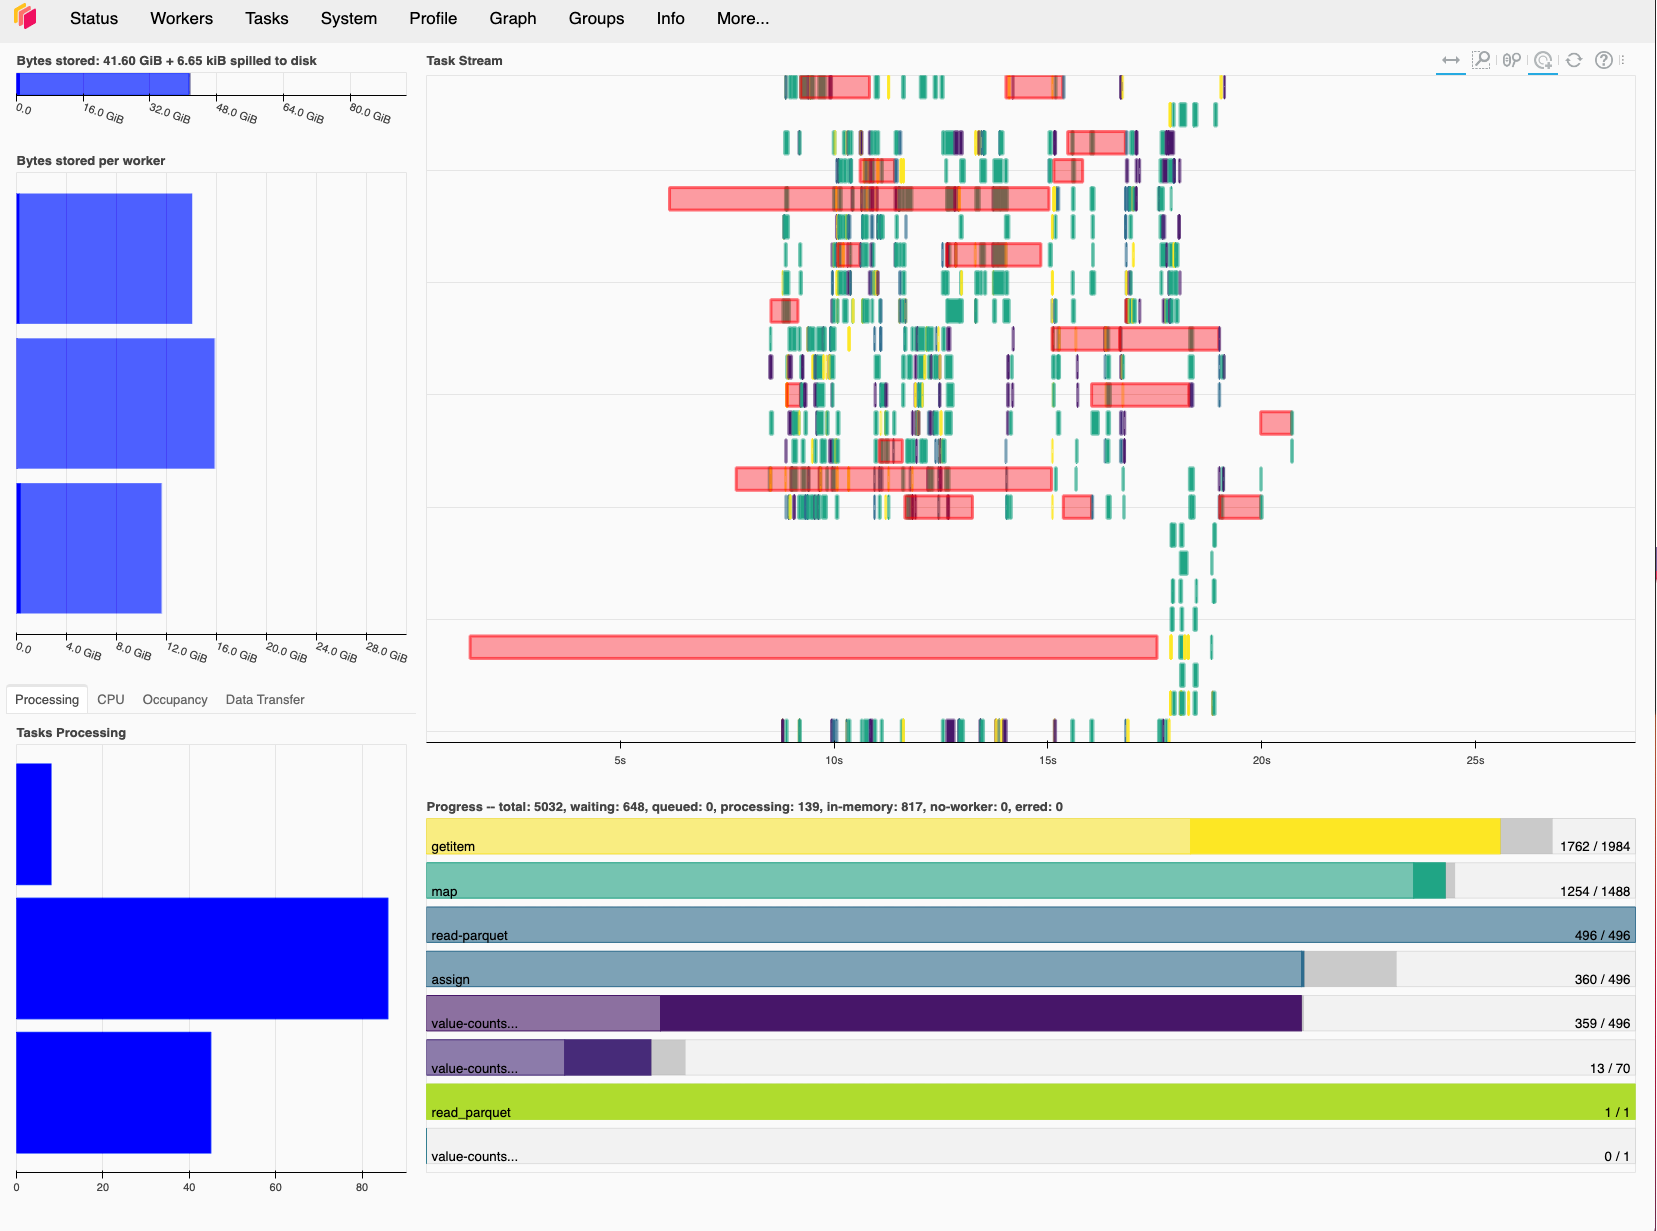

Let's assign an H3 cell id at level 5 to every POI:

In [ ]:
import h3

eupois_h3 = eupois.map_partitions(lambda df: df.assign(h3=[
    h3.geo_to_h3(lat, lon, 5) for lat, lon in zip(df['latitude'], df['longitude'])]))

eupois_h3.head()

With that we can generate a simle heatmap again using the group by call:

In [ ]:
%%time
eupoi_heatmap = eupois_h3[['h3']].groupby(by=['h3']).agg(count=("h3", "count"))
eupoi_heatmap = eupoi_heatmap.reset_index().compute()
eupoi_heatmap.sort_values('count', ascending=False)

In [ ]:
len(eupoi_heatmap[eupoi_heatmap['count'] > 500])

In [ ]:
h3heatmap(eupoi_heatmap[eupoi_heatmap['count'] > 500])

Let's now look just at bicycle parkings and prepare a slightly more detailed headmap (H3 level 6):

In [ ]:
%%time
len(eupois_h3[eupois_h3['amenity'] == 'bicycle_parking'])

In [ ]:
bicycle_parking_pois = eupois_h3[eupois_h3['amenity'] == 'bicycle_parking']
bicycle_parking_heatmap = bicycle_parking_pois[['h3']].groupby(by=['h3']).agg(
    count=("h3", "count")).reset_index().compute()
bicycle_parking_heatmap.sort_values('count', ascending=False)

In [ ]:
#TODO how many cells do have more than 10 bicycle parkings
??

In [ ]:
h3heatmap(bicycle_parking_heatmap[bicycle_parking_heatmap['count'] > 10])

In [ ]:
%%time
bicycle_parking_pois = eupois_h3[eupois_h3['amenity'] == 'bicycle_parking']
bicycle_parking_pois = bicycle_parking_pois.map_partitions(lambda df: df.assign(h3=[
    h3.geo_to_h3(lat, lon, 6) for lat, lon in zip(df['latitude'], df['longitude'])]))
bicycle_parking_heatmap = bicycle_parking_pois[['h3']].groupby(by=['h3']).agg(
    count=("h3", "count")).reset_index().compute()
bicycle_parking_heatmap.sort_values('count', ascending=False)

In [ ]:
len(bicycle_parking_heatmap[bicycle_parking_heatmap['count'] > 5])

In [ ]:
h3heatmap(bicycle_parking_heatmap[bicycle_parking_heatmap['count'] > 5])

Now finally let's open a population dataset to be able to compare OSM values in comparison to the population density.

For that we can use the kontur dataset which is available as H3 level 8 hexagons. The data was downloaded from https://data.humdata.org/dataset/kontur-population-dataset?force_layout=desktop and converted into a simple parquet file.

In [ ]:
fkontur = client.submit(dd.read_parquet, '/data/kontur/kontur_population_20220630.parquet', engine='pyarrow')
population = fkontur.result()
population.head()

In [ ]:
len(population)

Again we're having a look at bicycle parkings, this time we're using H3 cells at level 8 (finer grained):

In [ ]:
%%time
bicycle_parking_pois = eupois_h3[eupois_h3['amenity'] == 'bicycle_parking']
bicycle_parking_pois = bicycle_parking_pois.map_partitions(lambda df: df.assign(h3=[
    h3.geo_to_h3(lat, lon, 8) for lat, lon in zip(df['latitude'], df['longitude'])]))
bicycle_parking_heatmap = bicycle_parking_pois[['h3']].groupby(by=['h3']).agg(
    count=("h3", "count")).reset_index().compute()
bicycle_parking_heatmap.sort_values('count', ascending=False)

In [ ]:
len(bicycle_parking_heatmap[bicycle_parking_heatmap['count'] > 1])

Let's repeat this aggregation on the server and now directly join (merge) the heatmap with the population dataset using the H3 ids as key:

In [ ]:
%%time
bicycle_parking_pois = eupois_h3[eupois_h3['amenity'] == 'bicycle_parking']
bicycle_parking_pois = bicycle_parking_pois.map_partitions(lambda df: df.assign(h3=[
    h3.geo_to_h3(lat, lon, 8) for lat, lon in zip(df['latitude'], df['longitude'])]))
bicycle_parking_heatmap = bicycle_parking_pois[['h3']].groupby(by=['h3']).agg(
    count=("h3", "count")).reset_index()
bicycle_parking_density = bicycle_parking_heatmap.merge(population, on=['h3'])
bicycle_parking_density

In [ ]:
%%time
bicycle_parking_density = bicycle_parking_density.compute()
bicycle_parking_density

Now we can compute a density or other comparisons of the POI count in relation to the population:

In [ ]:
bicycle_parking_density['density'] = bicycle_parking_density['count'] / bicycle_parking_density['population']
bicycle_parking_density

In [ ]:
bicycle_parking_density['density'].hist(bins=100, log=True)

In [ ]:
len(bicycle_parking_density[bicycle_parking_density['density'] > 0.1])

In [ ]:
bicycle_parking_density['heat'] = (bicycle_parking_density['density'] * 100).astype(int)
bicycle_parking_density

In [ ]:
h3heatmap(bicycle_parking_density[
    (bicycle_parking_density['density'] > 0.1)
#     & (bicycle_parking_density['count'] > 1)
], column_name="density")

In [ ]:
# TODO can you come up with a different density or comparison idea?